In [4]:
#| default_exp sparse.sparsifier

In [36]:
#| include: false
from nbdev.showdoc import *
from fastai.vision.all import *

In [6]:
#| export
import numpy as np
from itertools import cycle
import torch
import torch.nn as nn
from fastcore.basics import store_attr, listify
from fasterai.core.criteria import *
import pickle

In [7]:
#| include: false
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

A sparse vector, as opposed to a dense one, is a vector which contains a lot of zeroes. When we speak about making a neural network sparse, we thus mean that the network's weight are mostly zeroes.

With fasterai, you can do that thanks to the `Sparsifier` class.

Let's start by creating a model

In [8]:
model = resnet18()

As you probably know, weights in a convolutional neural network have 4 dimensions ($ c_{out} \times c_{in} \times k_h \times k_w$)

In [9]:
model.conv1.weight.ndim

4

In [12]:
#| include: false
def plot_kernels(layer, save=None):
    kernels = abs(layer.weight.detach().clone())
    kernels = kernels - kernels.min()
    kernels = kernels/kernels.max()
    
    #plt.figure(figsize=(10,10))
    fig, ax = plt.subplots(1, 1, figsize=(10,10), dpi=100)
    fig.patch.set_alpha(0.)
    ax.patch.set_alpha(0.)
    img = make_grid(kernels, nrow=8, padding=1, pad_value=0.137)
    plt.axis('off')
    plt.imshow(img.detach().permute(1,2,0).cpu())
    if save: plt.savefig(f'{save}.pdf')

In the case of ResNet18, the dimension of the first layer weights is $64 \times 3 \times 7 \times 7$. We thus can plot each of the $64$ filter as a $7 \times 7$ color image (because they contains $3$ channels).

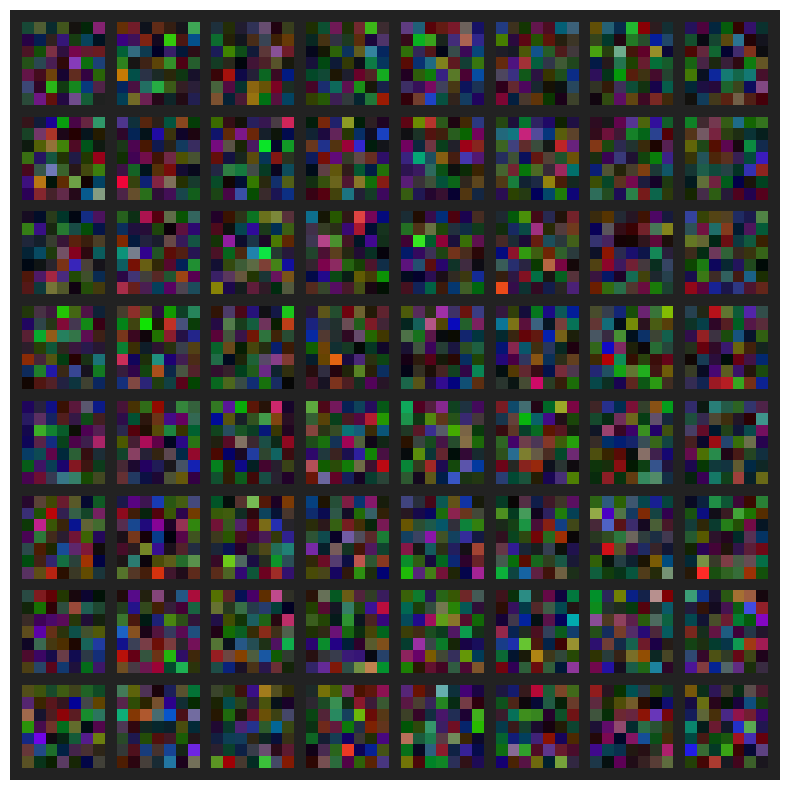

In [13]:
plot_kernels(model.conv1)

In [14]:
#| export
class Sparsifier():
    def __init__(self, model, granularity, context, criteria, layer_type=nn.Conv2d):
        store_attr()
        self._save_weights() # Save the original weights

    def prune_layer(self, m, sparsity, round_to=None, k=0):
        scores = self.criteria(m)
        setattr(m, '_mask', self._compute_mask(m, scores, sparsity, round_to))
        self._apply(m)
        self.criteria.update_weights(m)

    def prune_model(self, sparsity, round_to=None):
        self.threshold=None
        sparsity_list = listify(sparsity)
        if len(sparsity_list)>1: assert self.context=='local', f"A list of sparsities cannot be passed using: {self.context}"
        sparsities = cycle(sparsity_list) if len(sparsity_list)==1 else iter(sparsity_list)
        mods = list(self.model.modules())
        for k,m in enumerate(self.model.modules()):
            if isinstance(m, self.layer_type): 
                sp = next(sparsities)
                self.prune_layer(m, sp, round_to,k)
                if isinstance(mods[k+1], nn.modules.batchnorm._BatchNorm): self.prune_batchnorm(m, mods[k+1])
                
    def prune_batchnorm(self, m, bn):
        mask = getattr(m, "_mask", None)
        if self.granularity == 'filter' and mask is not None:
            bn.weight.data.mul_(mask.squeeze())
            bn.bias.data.mul_(mask.squeeze())
            
    def _apply_masks(self):
        for m in self.model.modules():
            if isinstance(m, self.layer_type):
                self._apply(m)
        
    def _apply(self, m):
        mask = getattr(m, "_mask", None)
        if mask is not None: m.weight.data.mul_(mask)
        if self.granularity == 'filter' and m.bias is not None:
            if mask is not None: m.bias.data.mul_(mask.squeeze()) # We want to prune the bias when pruning filters
    
    def _reset_weights(self, model=None):
        if not model: model=self.model
        for m in model.modules():
            if hasattr(m, 'weight'):
                init_weights = getattr(m, "_init_weights", m.weight)
                init_biases = getattr(m, "_init_biases", m.bias)
                with torch.no_grad():
                    if m.weight is not None: m.weight.copy_(init_weights)
                    if m.bias is not None: m.bias.copy_(init_biases)
                self._apply(m)
            if isinstance(m, nn.modules.batchnorm._BatchNorm): m.reset_parameters()
                
    def _save_weights(self):
        for m in self.model.modules():
            if hasattr(m, 'weight'):              
                m.register_buffer("_init_weights", m.weight.clone())
                b = getattr(m, 'bias', None)
                if b is not None: m.register_buffer("_init_biases", b.clone())
                    
    def save_model(self, path, model=None):
        if not model: model=self.model
        tmp_model = pickle.loads(pickle.dumps(model))
        self._reset_weights(tmp_model)
        self._clean_buffers(tmp_model)
        torch.save(tmp_model, path)

    def _clean_buffers(self, model=None):
        if not model: model=self.model
        for m in model.modules():
            if hasattr(m, 'weight'):
                if hasattr(m, '_mask'): del m._buffers["_mask"]
                if hasattr(m, '_init_weights'): del m._buffers["_init_weights"]
                if hasattr(m, '_init_biases'): del m._buffers["_init_biases"]
    
    def _compute_threshold(self, m, scores, sparsity):
        if self.context == 'global':
            if self.threshold is None: 
                global_criteria = torch.cat([self.criteria(m).view(-1) for m in self.model.modules() if isinstance(m, self.layer_type)]) # Get all scores
                global_scores = torch.cat([self.criteria.get_scores(m, self.criteria(m), self.granularity, global_criteria.min()).view(-1) for m in self.model.modules() if isinstance(m, self.layer_type)])
                self.threshold = torch.quantile(global_scores, sparsity/100) # Compute the threshold globally (only once per model pruning)
            scores = self.criteria.get_scores(m, scores, self.granularity, self.criteria.min_value) # min_value is computed only once per prune_model
            return self.threshold, scores
        elif self.context == 'local':
            scores = self.criteria.get_scores(m, scores, self.granularity)
            return torch.quantile(scores.view(-1), sparsity/100), scores
        else: raise NameError('Invalid Context')

    def _rounded_sparsity(self, n_to_prune, round_to):
        return max(round_to*torch.ceil(n_to_prune/round_to), round_to)
    
    def _compute_mask(self, m, scores, sparsity, round_to):
        self.threshold, scores = self._compute_threshold(m, scores, sparsity)
        if round_to:
            n_to_keep = sum(scores.ge(self.threshold)).squeeze()
            self.threshold = torch.topk(scores.squeeze(), int(self._rounded_sparsity(n_to_keep, round_to)))[0].min()
        if self.threshold > scores.max(): self.threshold = scores.max() # Make sure we don't remove every weight of a given layer
        return scores.ge(self.threshold).to(dtype=scores.dtype)
    
    def print_sparsity(self):
        for k,m in enumerate(self.model.modules()):
            if isinstance(m, self.layer_type):
                print(f"Sparsity in {m.__class__.__name__} {k}: {100. * float(torch.sum(m.weight == 0))/ float(m.weight.nelement()):.2f}%")

The `Sparsifier` class allows us to remove some (part of) the filters, that are considered to be less useful than others. This can be done by first creating an instance of the class, specifying:

- The `granularity`, i.e. the part of filters that you want to remove. Typically, we usually remove weights, vectors, kernels or even complete filters.
- The `context`, i.e. if you want to consider each layer independently (`local`), or compare the parameters to remove across the whole network (`global`).
- The `criteria`, i.e. the way to assess the usefulness of a parameter. Common methods compare parameters using their magnitude, the lowest magnitude ones considered to be less useful.

User can pass a single layer to prune by using the  `Sparsifier.prune_layer` method.

In [15]:
show_doc(Sparsifier.prune_layer)

---

### Sparsifier.prune_layer

>      Sparsifier.prune_layer (m, sparsity, round_to=None, k=0)

In [16]:
model = resnet18()
pruner = Sparsifier(model, 'filter', 'local', large_final)
pruner.prune_layer(model.conv1, 70)

In [17]:
pruner.print_sparsity()

Sparsity in Conv2d 1: 70.31%
Sparsity in Conv2d 7: 0.00%
Sparsity in Conv2d 10: 0.00%
Sparsity in Conv2d 13: 0.00%
Sparsity in Conv2d 16: 0.00%
Sparsity in Conv2d 20: 0.00%
Sparsity in Conv2d 23: 0.00%
Sparsity in Conv2d 26: 0.00%
Sparsity in Conv2d 29: 0.00%
Sparsity in Conv2d 32: 0.00%
Sparsity in Conv2d 36: 0.00%
Sparsity in Conv2d 39: 0.00%
Sparsity in Conv2d 42: 0.00%
Sparsity in Conv2d 45: 0.00%
Sparsity in Conv2d 48: 0.00%
Sparsity in Conv2d 52: 0.00%
Sparsity in Conv2d 55: 0.00%
Sparsity in Conv2d 58: 0.00%
Sparsity in Conv2d 61: 0.00%
Sparsity in Conv2d 64: 0.00%


Most of the time, we may want to prune the whole model at once, using the `Sparsifier.prune_model` method, indicating the percentage of sparsity to you want to apply.

In [18]:
show_doc(Sparsifier.prune_model)

---

### Sparsifier.prune_model

>      Sparsifier.prune_model (sparsity, round_to=None)

There are several ways in which we can make that first layer sparse. You will find the most important below:

In [19]:
model = resnet18()
pruner = Sparsifier(model, 'weight', 'local', large_final)
pruner.prune_model(70)

In [20]:
pruner.print_sparsity()

Sparsity in Conv2d 1: 69.99%
Sparsity in Conv2d 7: 70.00%
Sparsity in Conv2d 10: 70.00%
Sparsity in Conv2d 13: 70.00%
Sparsity in Conv2d 16: 70.00%
Sparsity in Conv2d 20: 70.00%
Sparsity in Conv2d 23: 70.00%
Sparsity in Conv2d 26: 70.00%
Sparsity in Conv2d 29: 70.00%
Sparsity in Conv2d 32: 70.00%
Sparsity in Conv2d 36: 70.00%
Sparsity in Conv2d 39: 70.00%
Sparsity in Conv2d 42: 70.00%
Sparsity in Conv2d 45: 70.00%
Sparsity in Conv2d 48: 70.00%
Sparsity in Conv2d 52: 70.00%
Sparsity in Conv2d 55: 70.00%
Sparsity in Conv2d 58: 70.00%
Sparsity in Conv2d 61: 70.00%
Sparsity in Conv2d 64: 70.00%


You now have a model that is $70\%$ sparse ! 

## Granularity

As we said earlier, the `granularity` defines the structure of parameter that you will remove.

In the example below, we removed `weight` from each convolutional filter, meaning that we now have sparse filters, as can be seen in the image below:

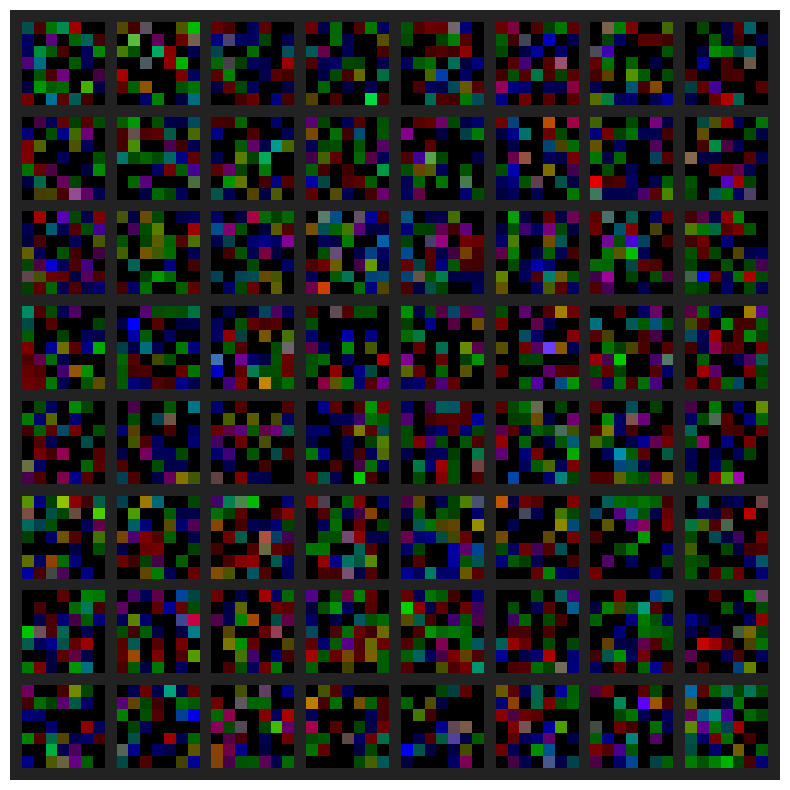

In [21]:
plot_kernels(model.conv1)

Another granularity is, for example, removing `column` vectors from the filters. To do so, just change the granularity parameter accordingly.

In [22]:
model = resnet18()
pruner = Sparsifier(model, 'column', 'local', large_final)
pruner.prune_layer(model.conv1, 70)

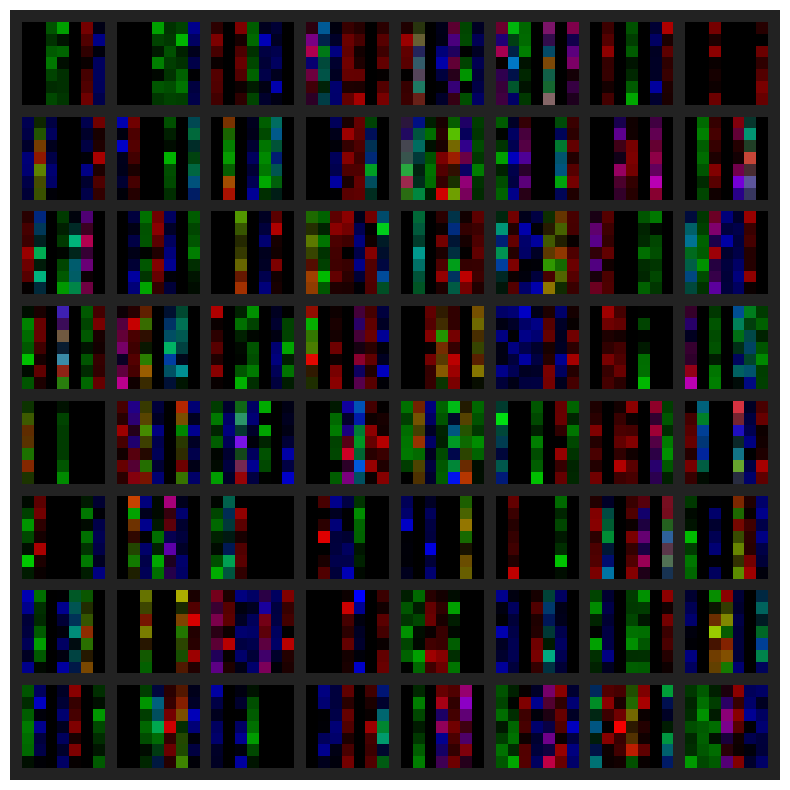

In [23]:
plot_kernels(model.conv1)

For more information and examples about the pruning granularities, I suggest you to take a look at the [corresponding section](https://nathanhubens.github.io/fasterai/granularity.html).

## Context

The context defines where to look in the model, i.e. from where do we compare weight. The two basic contexts are:
- `local`, i.e. we compare weight from each layer individually. This will lead to layers with similar levels of sparsity.
- `global`, i.e. we compare weight from the whole model. This will lead to layers with different levels of sparsity

In [24]:
model = resnet18()
pruner = Sparsifier(model, 'weight', 'local', large_final)
pruner.prune_model(70)

In [25]:
pruner.print_sparsity()

Sparsity in Conv2d 1: 69.99%
Sparsity in Conv2d 7: 70.00%
Sparsity in Conv2d 10: 70.00%
Sparsity in Conv2d 13: 70.00%
Sparsity in Conv2d 16: 70.00%
Sparsity in Conv2d 20: 70.00%
Sparsity in Conv2d 23: 70.00%
Sparsity in Conv2d 26: 70.00%
Sparsity in Conv2d 29: 70.00%
Sparsity in Conv2d 32: 70.00%
Sparsity in Conv2d 36: 70.00%
Sparsity in Conv2d 39: 70.00%
Sparsity in Conv2d 42: 70.00%
Sparsity in Conv2d 45: 70.00%
Sparsity in Conv2d 48: 70.00%
Sparsity in Conv2d 52: 70.00%
Sparsity in Conv2d 55: 70.00%
Sparsity in Conv2d 58: 70.00%
Sparsity in Conv2d 61: 70.00%
Sparsity in Conv2d 64: 70.00%


In [26]:
model = resnet18()
pruner = Sparsifier(model, 'weight', 'global', large_final)
pruner.prune_model(70)

In [27]:
pruner.print_sparsity()

Sparsity in Conv2d 1: 66.20%
Sparsity in Conv2d 7: 32.18%
Sparsity in Conv2d 10: 32.09%
Sparsity in Conv2d 13: 31.96%
Sparsity in Conv2d 16: 32.15%
Sparsity in Conv2d 20: 44.07%
Sparsity in Conv2d 23: 44.04%
Sparsity in Conv2d 26: 16.02%
Sparsity in Conv2d 29: 44.15%
Sparsity in Conv2d 32: 44.09%
Sparsity in Conv2d 36: 59.25%
Sparsity in Conv2d 39: 59.30%
Sparsity in Conv2d 42: 22.06%
Sparsity in Conv2d 45: 59.29%
Sparsity in Conv2d 48: 59.30%
Sparsity in Conv2d 52: 75.90%
Sparsity in Conv2d 55: 75.85%
Sparsity in Conv2d 58: 30.31%
Sparsity in Conv2d 61: 75.82%
Sparsity in Conv2d 64: 75.86%


## Criteria

The `criteria` defines how we select the parameters to remove. It is usually given by a scoring method. The most common one is the `large_final`, i.e. select parameters with the highest absolute value as they are supposed to contribute the most to the final results of the model.

In [28]:
model = resnet18()
pruner = Sparsifier(model, 'weight', 'global', large_final)
pruner.prune_model(70)

In [29]:
pruner.print_sparsity()

Sparsity in Conv2d 1: 67.08%
Sparsity in Conv2d 7: 32.25%
Sparsity in Conv2d 10: 31.98%
Sparsity in Conv2d 13: 32.28%
Sparsity in Conv2d 16: 31.94%
Sparsity in Conv2d 20: 44.52%
Sparsity in Conv2d 23: 44.23%
Sparsity in Conv2d 26: 15.36%
Sparsity in Conv2d 29: 44.36%
Sparsity in Conv2d 32: 44.24%
Sparsity in Conv2d 36: 59.27%
Sparsity in Conv2d 39: 59.10%
Sparsity in Conv2d 42: 21.94%
Sparsity in Conv2d 45: 59.21%
Sparsity in Conv2d 48: 59.23%
Sparsity in Conv2d 52: 75.89%
Sparsity in Conv2d 55: 75.82%
Sparsity in Conv2d 58: 30.38%
Sparsity in Conv2d 61: 75.90%
Sparsity in Conv2d 64: 75.85%


In [30]:
model = resnet18()
pruner = Sparsifier(model, 'weight', 'global', small_final)
pruner.prune_model(70)

In [31]:
pruner.print_sparsity()

Sparsity in Conv2d 1: 72.49%
Sparsity in Conv2d 7: 87.78%
Sparsity in Conv2d 10: 87.88%
Sparsity in Conv2d 13: 87.83%
Sparsity in Conv2d 16: 87.99%
Sparsity in Conv2d 20: 83.05%
Sparsity in Conv2d 23: 83.02%
Sparsity in Conv2d 26: 94.21%
Sparsity in Conv2d 29: 83.10%
Sparsity in Conv2d 32: 83.07%
Sparsity in Conv2d 36: 76.27%
Sparsity in Conv2d 39: 76.20%
Sparsity in Conv2d 42: 92.01%
Sparsity in Conv2d 45: 76.22%
Sparsity in Conv2d 48: 76.26%
Sparsity in Conv2d 52: 66.89%
Sparsity in Conv2d 55: 66.87%
Sparsity in Conv2d 58: 88.72%
Sparsity in Conv2d 61: 66.95%
Sparsity in Conv2d 64: 66.87%


For more information and examples about the pruning criteria, I suggest you to take a look at the [corresponding section](https://nathanhubens.github.io/fasterai/criteria.html).

## Remark

In some case, you may want to impose the remaining amount of parameters to be a multiple of 8, this can be done by passing the `round_to` parameter.

In [32]:
model = resnet18()
pruner = Sparsifier(model, 'filter', 'local', large_final)
pruner.prune_model(70, round_to=8)

In [33]:
pruner.print_sparsity()

Sparsity in Conv2d 1: 62.50%
Sparsity in Conv2d 7: 62.50%
Sparsity in Conv2d 10: 62.50%
Sparsity in Conv2d 13: 62.50%
Sparsity in Conv2d 16: 62.50%
Sparsity in Conv2d 20: 68.75%
Sparsity in Conv2d 23: 68.75%
Sparsity in Conv2d 26: 68.75%
Sparsity in Conv2d 29: 68.75%
Sparsity in Conv2d 32: 68.75%
Sparsity in Conv2d 36: 68.75%
Sparsity in Conv2d 39: 68.75%
Sparsity in Conv2d 42: 68.75%
Sparsity in Conv2d 45: 68.75%
Sparsity in Conv2d 48: 68.75%
Sparsity in Conv2d 52: 68.75%
Sparsity in Conv2d 55: 68.75%
Sparsity in Conv2d 58: 68.75%
Sparsity in Conv2d 61: 68.75%
Sparsity in Conv2d 64: 68.75%


In [34]:
model = resnet18()
pruner = Sparsifier(model, 'filter', 'global', large_final)
pruner.prune_model(70, round_to=8)

In [35]:
pruner.print_sparsity()

Sparsity in Conv2d 1: 87.50%
Sparsity in Conv2d 7: 0.00%
Sparsity in Conv2d 10: 0.00%
Sparsity in Conv2d 13: 0.00%
Sparsity in Conv2d 16: 0.00%
Sparsity in Conv2d 20: 93.75%
Sparsity in Conv2d 23: 93.75%
Sparsity in Conv2d 26: 0.00%
Sparsity in Conv2d 29: 93.75%
Sparsity in Conv2d 32: 93.75%
Sparsity in Conv2d 36: 96.88%
Sparsity in Conv2d 39: 96.88%
Sparsity in Conv2d 42: 0.00%
Sparsity in Conv2d 45: 96.88%
Sparsity in Conv2d 48: 90.62%
Sparsity in Conv2d 52: 98.44%
Sparsity in Conv2d 55: 98.44%
Sparsity in Conv2d 58: 0.00%
Sparsity in Conv2d 61: 98.44%
Sparsity in Conv2d 64: 98.44%


For more information about granularities at which you can operate, please check the [related page](https://nathanhubens.github.io/fasterai/granularity.html).